# Does the KSD approximation work?

In [1]:
import sys
sys.path.append("/home/lauro/code/msc-thesis/svgd")

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index

import matplotlib.pyplot as plt
import numpy as onp
from tqdm import tqdm
import time
from functools import partial

import utils
import metrics
import plot
from svgd import SVGD
import svgd
import stein
import kernels

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Using optimizers

In [2]:
from jax.experimental import optimizers
from stein import ksd_squared

## SVGD and  KSD update

In [3]:
n = 100
dist = metrics.Gaussian(0, 1)

In [12]:
def init_svgd(key, particle_shape):
    return random.normal(key, particle_shape) * 2 - 3

def apply_svgd():
    pass

@partial(jit, static_argnums=1)
def phistar(xs, logp, kernel_params):
    return svgd.phistar(xs, logp, kernels.ard(kernel_params))

# Initialize particles
particles0 = init_svgd(rkey, (n, 1))

# initialize optimizer states
svgd_stepsize = 0.05
opt_init, opt_update, get_params = optimizers.sgd(step_size=svgd_stepsize)
# opt_init, opt_update, get_params = optimizers.adagrad(step_size=0.1, momentum=0.9)
opt_state = opt_init(particles0) # now opt has stored particles in its state

In [5]:
n_iter = 500
ps = []

kernel_params = 0.

for i in range(n_iter):
    particles = get_params(opt_state)
    ps.append(particles)

    # update particles:
    gp = -phistar(particles, dist.logpdf, kernel_params)
    opt_state= opt_update(i, gp, opt_state)

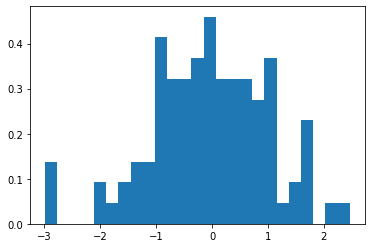

In [6]:
_ = plt.hist(ps[-1][:, 0], density=True, bins=25)

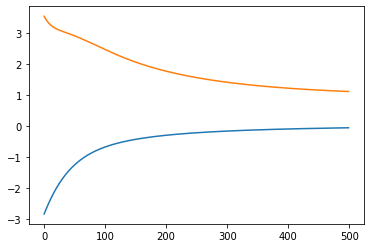

In [7]:
_ = plt.plot([np.mean(p) for p in ps])
_ = plt.plot([np.var(p)  for p in ps])

## analytics

In [8]:
@partial(jit, static_argnums=1)
def ksd_squared(samples, logp, kernel_params):
    return stein.ksd_squared(samples, logp, kernels.ard(kernel_params))

In [9]:
ksds = [ksd_squared(p, dist.logpdf, kernel_params) for p in ps]
ksds = np.asarray(ksds)

kls = [dist.kl_divergence(p) for p in ps]
kls = np.asarray(ksds)

Assumption: (if step size is $\varepsilon$)
$$
\varepsilon \cdot \text{KSD}(q \ \Vert \ p)^2 \approx \text{KL}(q \ \Vert \ p) - \text{KL}(q' \ \Vert \ p).
$$

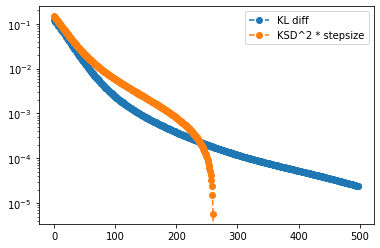

In [15]:
fig, ax = plt.subplots()

ax.plot(-np.diff(kls), "--o", label="KL diff")
ax.plot(svgd_stepsize * ksds[:-1], "--o", label="KSD^2 * stepsize")
ax.legend()
ax.set_yscale("log")